In [2]:
%load_ext autoreload
%autoreload 1
%aimport my, net

import sys
import numpy as np
import pandas as pd

import os
import gc
import matplotlib.pyplot as plt
import importlib
import pickle
import logging

import my, net
from my import p
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option("max_colwidth", 45)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.5f}".format
# pd.set_option("display.max_rows", 5)
# pd.reset_option("display.max_rows")

from sklearn.model_selection import train_test_split

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
     
out = "out/"
da = 'data/'

SEED = 34
np.random.seed(SEED)
N_CPU = os.cpu_count()
os.makedirs(out,exist_ok=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv(da+'train.csv')
p(df.shape)
df[:5]

(6151, 3)


,context,answer,label
0,**Вы:** Спасибо большое)).\nКакую музыку ...,"Ой, ну тогда давай я тебе порекомендую чт...",ai
1,**Вы:** Я тоже не замужем. Ищу своего при...,"Может быть и тихие, но совсем не мирные, ...",people
2,**Вы:** Ивановская область.\n\n**Собеседн...,В деревне у меня на даче.,ai
3,**Вы:** Особенно чинить их.\n\n**Собеседн...,"В доме - полный порядок, все на своем месте.",ai
4,**Вы:** В свободное время.\n\n**Собеседни...,"Да, я фотографирую, это моя страсть и хобби.",ai


In [4]:
te = pd.read_csv(da+'public_test.csv')
p(te.shape)
te[:5]

(1636, 2)


,context,answer
0,**Вы:** Я бы тоже с удовольствием « под г...,"Круто) Природа, романтика, гитара, костер..."
1,"**Вы:** Ну, что рассказать, работаю на ст...",На бирже играю плюс испанский язык учу. Л...
2,**Вы:** Вот на днях старший( 10 лет) заяв...,"Как же здорово, что ты наконец-то решился..."
3,**Вы:** А я играю на пианинр.\nА я играю ...,"О, я бы с удовольствием приехал в Анапу и..."
4,**Вы:** Достаточно неординарное сравнение...,"Нет, я не умею делать анимации, но мне бы..."


In [7]:
df['text'] = df['answer']
te['text'] = te['answer']
df[:3]

,context,answer,label,text
0,@@первый@@ Спасибо большое)).\nКакую музы...,"Ой, ну тогда давай я тебе порекомендую чт...",ai,"Ой, ну тогда давай я тебе порекомендую чт..."
1,@@первый@@ Я тоже не замужем. Ищу своего ...,"Может быть и тихие, но совсем не мирные, ...",people,"Может быть и тихие, но совсем не мирные, ..."
2,@@первый@@ Ивановская область.\n\n@@второ...,В деревне у меня на даче.,ai,В деревне у меня на даче.


In [8]:
from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    PreTrainedTokenizerFast,
    TrainingArguments,
    default_data_collator,
    Trainer
)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
tokenizer.is_fast

True

count   6151.00000
mean      15.58267
std        8.84041
min        3.00000
25%        9.00000
50%       14.00000
75%       19.00000
max      142.00000
dtype: float64

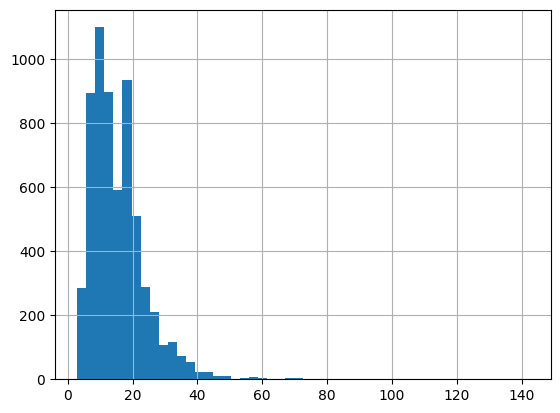

In [10]:
def len_in_tokens(se, tokenizer, plot=True):
    encs = tokenizer(se.to_list(), padding=False, truncation=False)
    if plot:
        t_len = pd.Series([len(x) for x in encs["input_ids"]])
        t_len.hist(bins=50)
    return t_len

t_len = len_in_tokens(df['text'], tokenizer)
t_len.describe()

count   1636.00000
mean      15.95966
std        9.08052
min        3.00000
25%        9.00000
50%       14.00000
75%       20.00000
max       91.00000
dtype: float64

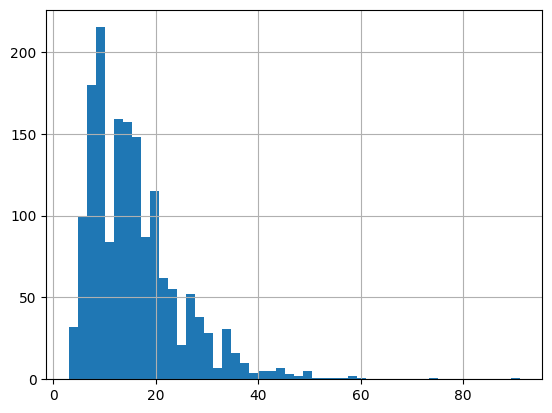

In [11]:
t_len1 = len_in_tokens(te['text'], tokenizer)
t_len1.describe()

In [12]:
len_text = pd.qcut(t_len,q=10, labels=False)
len_text[:3]

0    9
1    8
2    1
dtype: int64

In [13]:
df['label'] = df['label'].map({'people':0,'ai':1})
df['stratify'] = len_text * 10 + df['label']
df[:3]

,context,answer,label,text,stratify
0,@@первый@@ Спасибо большое)).\nКакую музы...,"Ой, ну тогда давай я тебе порекомендую чт...",1,"Ой, ну тогда давай я тебе порекомендую чт...",91
1,@@первый@@ Я тоже не замужем. Ищу своего ...,"Может быть и тихие, но совсем не мирные, ...",0,"Может быть и тихие, но совсем не мирные, ...",80
2,@@первый@@ Ивановская область.\n\n@@второ...,В деревне у меня на даче.,1,В деревне у меня на даче.,11


In [14]:
df = my.add_folds(df,strat_col='stratify', n_folds=7,seed=SEED)
df[:3]

StratifiedKFold


,context,answer,label,text,stratify,fold
0,@@первый@@ Спасибо большое)).\nКакую музы...,"Ой, ну тогда давай я тебе порекомендую чт...",1,"Ой, ну тогда давай я тебе порекомендую чт...",91,3
1,@@первый@@ Я тоже не замужем. Ищу своего ...,"Может быть и тихие, но совсем не мирные, ...",0,"Может быть и тихие, но совсем не мирные, ...",80,0
2,@@первый@@ Ивановская область.\n\n@@второ...,В деревне у меня на даче.,1,В деревне у меня на даче.,11,2


In [15]:
df['fold'].value_counts()

3    879
0    879
2    879
1    879
4    879
6    878
5    878
Name: fold, dtype: int64

In [16]:
# !rm -rf out/bert_model

In [17]:
CHECKPOINT_DIR = out + 'bert_model/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_DIR

'out/bert_model/'

In [18]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar, ModelCheckpoint
from pytorch_lightning.plugins.precision import MixedPrecisionPlugin

torch.set_float32_matmul_precision('medium')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class CFG:
    model_name = 'cointegrated/LaBSE-en-ru'
#     model_name = 'sberbank-ai/ruRoberta-large'
    threshold = 0.5
    scheduler='cosine'
    num_cycles=0.5
    num_warmup_steps=30
    epochs=12
    batch_size=16
    val_batch_size = 32
    max_length = 80
    gradient_checkpointing=False
    gradient_accumulation_steps=1
    max_grad_norm=10
    precision = 16

def train_fold(Xy:pd.DataFrame, Xy_test:pd.DataFrame, fold:int=0):
    print('[TRAIN FOLD]:',fold)
    net.set_seed(SEED + 10*fold)
    NAME_CKPT = f'best_f{fold}'

    dm = net.BertDataModule(Xy, Xy_test, fold=fold, batch_size = CFG.batch_size, val_bs=CFG.val_batch_size,  n_cpu=3, cfg=CFG)

    CFG.num_train_steps = int(dm.len_train/CFG.batch_size*CFG.epochs)

    model = net.BertModule(CFG, lr = 2e-5)
    
#     for n,param in model.named_parameters():
#         if ('10' in n) or ('11' in n) or ('pooler' in n) or ('clf' in n):
#             continue
#         param.requires_grad = False

    tq = TQDMProgressBar(refresh_rate=50)

    es = EarlyStopping('val_f1', min_delta=0.001,patience=4,verbose=True, mode='max', check_on_train_epoch_end=False)

    chpt = ModelCheckpoint(dirpath=CHECKPOINT_DIR,filename=f'best_f{fold}',  monitor='val_f1',mode='max')

    trainer = pl.Trainer(
        precision=CFG.precision,
        plugins=[MixedPrecisionPlugin(precision=16,device='cuda')],
    callbacks=[tq,es,chpt],
    max_epochs=CFG.epochs,
    deterministic = True,
    accelerator='auto',
    accumulate_grad_batches = CFG.gradient_accumulation_steps,
    gradient_clip_val = CFG.max_grad_norm,
    log_every_n_steps = 50,
    enable_model_summary = True if fold==0 else False,
    # val_check_interval = 1.,
#         auto_lr_find=True
    )
    trainer.fit(model, datamodule=dm)

    del trainer
    torch.cuda.empty_cache()
    gc.collect()

    model = net.BertModule.load_from_checkpoint(checkpoint_path=chpt.best_model_path).to(net.device)

    return chpt.best_model_score.cpu().item()

res = []
# for fold in sorted(df['fold'].unique()):
for fold in range(0,7):
    res_fold = train_fold(df, te, fold=fold)
    res.append((fold,res_fold))
    print('val_f1: ',res_fold)
#     break

[TRAIN FOLD]: 0


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historic

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_f1:  0.911475419998169
[TRAIN FOLD]: 1


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historic

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_f1:  0.9090909361839294
[TRAIN FOLD]: 2


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_f1:  0.9067524075508118
[TRAIN FOLD]: 3


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_f1:  0.9095127582550049
[TRAIN FOLD]: 4


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_f1:  0.932725191116333
[TRAIN FOLD]: 5


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_f1:  0.9182692170143127
[TRAIN FOLD]: 6


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


val_f1:  0.9214537143707275


In [19]:
pd.DataFrame(res, columns=['fold', 'val_f1'])

,fold,val_f1
0,0,0.91148
1,1,0.90909
2,2,0.90675
3,3,0.90951
4,4,0.93273
5,5,0.91827
6,6,0.92145


предсказание на тестовых данных

In [ ]:
scores = []
preds = []

# for fold in sorted(Xy['fold'].unique()):
for fold in range(0,7):
    dm = net.BertDataModule(df, te, fold=fold, batch_size = CFG.batch_size, n_cpu=3, cfg=CFG)
    dm.setup('fit')

    model = net.BertModule.load_from_checkpoint(checkpoint_path=CHECKPOINT_DIR+f'best_f{fold}.ckpt').to(net.device)
    model.eval()

    trainer = pl.Trainer(accelerator='gpu', devices=1)

    fold_test_pred = trainer.predict(model, dm)
    preds.append(torch.cat(fold_test_pred))
    
scores = pd.DataFrame(scores, columns=['fold', 'val_f1'])

In [24]:
mean_fold_preds = torch.mean(torch.cat(preds,axis=1), dim=1).cpu().numpy()
mean_fold_preds.shape

(1636,)

In [25]:
mean_fold_preds

array([0.00199777, 0.01629017, 0.99732417, ..., 0.00175128, 0.5639897 ,
       0.99013984], dtype=float32)

In [26]:
preds = pd.DataFrame(mean_fold_preds, columns=['label'])
preds

,label
0,0.00200
1,0.01629
2,0.99732
3,0.99704
4,0.99792
...,...
1631,0.00278
1632,0.91508
1633,0.00175
1634,0.56399


In [27]:
preds.to_csv('preds.csv',index=False)

несколько сабмитов с разных порогами

In [28]:
TH = 0.4
step = 0.02
for i in range(0,11):
    new_TH = 0.4 + (i*0.02)
    sub = preds.copy()
    sub['label'] = sub['label'].map(lambda x:'ai' if x > new_TH else 'people')
    sub.to_csv(f'sub_{round(new_TH,2)}.csv',index=False)

предсказание на финальных данных

In [ ]:
te = pd.read_csv(da+'private_test.csv')
te['text'] = te['answer']
p(te.shape)
te[:5]

In [ ]:
preds = []

for fold in range(0,7):
    dm = net.BertDataModule(df, te, fold=fold, batch_size = CFG.batch_size, n_cpu=3, cfg=CFG)
    dm.setup('fit')

    model = net.BertModule.load_from_checkpoint(checkpoint_path=CHECKPOINT_DIR+f'best_f{fold}.ckpt').to(net.device)
    model.eval()

    trainer = pl.Trainer(accelerator='gpu', devices=1)

    fold_test_pred = trainer.predict(model, dm)
    preds.append(torch.cat(fold_test_pred))

In [ ]:
mean_fold_preds = torch.mean(torch.cat(preds,axis=1), dim=1).cpu().numpy()
mean_fold_preds.shape

In [ ]:
preds = pd.DataFrame(mean_fold_preds, columns=['label'])
preds

In [ ]:
sub = preds.copy()
sub['label'] = sub['label'].map(lambda x:'ai' if x > 0.46 else 'people')
sub.to_csv(f'sub_private.csv',index=False)
sub